# Corrective RAG (CRAG) Implementation with LangGraph

The concept of Corrective Retrieval-Augmented Generation (CRAG) was introduced in the research paper titled **“Corrective Retrieval Augmented Generation” by Shi-Qi Yan, Jia-Chen Gu, Yun Zhu, and Zhen-Hua Ling**. This paper was first published on January 29, 2024 and is avilable at the following [link.](https://arxiv.org/abs/2401.15884?utm_source=chatgpt.com)

In their work, the authors address the issue of hallucinations in large language models (LLMs) and the challenges posed when retrieval-augmented generation (RAG) systems rely on irrelevant or incorrect documents. To enhance the robustness of generated outputs, they propose the Corrective Retrieval-Augmented Generation (CRAG) framework, which includes a lightweight **retrieval evaluator** to assess the quality of retrieved documents and determine appropriate corrective actions. Additionally, the framework incorporates **large-scale web searches** to supplement static data.

The goal of this project is to reproduce CRAG implementation based on the blog "Corrective RAG (CRAG) Implementation With LangGraph" by Ryan Ong / Datacamp.

## References

1. “Corrective Retrieval Augmented Generation” by Shi-Qi Yan, Jia-Chen Gu, Yun Zhu, and Zhen-Hua Ling, published on January 29, 2024 and available at the following [link.](https://arxiv.org/abs/2401.15884?utm_source=chatgpt.com)
⭐

2. "Corrective RAG (CRAG) Implementation With LangGraph" by Ryan Ong / Datacamp, available at this [link.](https://www.datacamp.com/tutorial/corrective-rag-crag)
⭐


### Setup

In [1]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "YOUR-PATH-HERE"

In [3]:
%%capture
!pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

In [4]:
%%capture
!pip install -U :class:`~langchain-openai

In [5]:
import os
os.environ["TAVILY_API_KEY"] = "YOUR-TAVILY-API-KEY-HERE"
os.environ["OPENAI_API_KEY"] = "YOUR-OPENAI-API-KEY-HERE"

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

### Preparing Knowledge Base By Scraping and Storing Documents

Let's load documents from URLs, split them into smaller chunks, embed them using OpenAIEmbeddings, and store them in a Chroma vector database for efficient retrieval.

In [7]:
# Loading documents

urls = [
    "https://www.kingarthurbaking.com/recipes/naturally-leavened-sourdough-bread-recipe",
    "https://www.kingarthurbaking.com/recipes/pain-de-campagne-country-bread-recipe",
    "https://www.kingarthurbaking.com/recipes/sourdough-pumpernickel-bread-recipe",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Remove duplicate document chunks before storing
unique_doc_splits = []
seen_sources = set()

for doc in doc_splits:
    source = doc.metadata.get("source", "N/A")
    if source not in seen_sources:
        seen_sources.add(source)
        unique_doc_splits.append(doc)

print(f"Storing {len(unique_doc_splits)} unique documents in VectorDB")

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

Storing 3 unique documents in VectorDB


In [8]:
print(f"Total documents before splitting: {len(docs_list)}")
print(f"Total documents after splitting: {len(doc_splits)}")

Total documents before splitting: 3
Total documents after splitting: 71


In [9]:
# Print the names (titles and sources) of the loaded documents
print("\n **Loaded Documents:**")
for i, doc in enumerate(docs_list, 1):
    source = doc.metadata.get('source', 'Unknown Source')  # Get source URL
    title = doc.metadata.get('title', 'Untitled Document')  # Get title (if available)
    print(f"{i}. **Title:** {title} \n   **Source:** {source}\n")


 **Loaded Documents:**
1. **Title:** Naturally Leavened Sourdough Bread Recipe | King Arthur Baking 
   **Source:** https://www.kingarthurbaking.com/recipes/naturally-leavened-sourdough-bread-recipe

2. **Title:** Pain de Campagne (Country Bread) Recipe | King Arthur Baking 
   **Source:** https://www.kingarthurbaking.com/recipes/pain-de-campagne-country-bread-recipe

3. **Title:** Sourdough Pumpernickel Bread Recipe | King Arthur Baking 
   **Source:** https://www.kingarthurbaking.com/recipes/sourdough-pumpernickel-bread-recipe



In [10]:
print(f"Total documents stored in vectorDB: {vectorstore._collection.count()}")

Total documents stored in vectorDB: 71


### Set Up Basic RAG

In [11]:
# Set up a basic RAG chain that retrieves relevant documents, uses GPT-4o mini to generate answers based on them.

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

rag_prompt = hub.pull("rlm/rag-prompt")
rag_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Function to format documents properly
def format_docs(docs):
    cleaned_docs = [" ".join(x.split()) for x in docs if x.strip()]  # Remove extra spaces and empty lines
    return "\n\n".join(cleaned_docs)  # Join with spacing for readability

# Define the basic RAG chain
rag_chain = rag_prompt | rag_llm | StrOutputParser()
print(rag_prompt.messages[0].prompt.template)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [12]:
# Check type of documents:
print("Type of docs:", type(docs))
print("Type of first element:", type(docs[0]))

Type of docs: <class 'list'>
Type of first element: <class 'list'>


In [13]:
# Flatten the list (if nested lists exist)
flat_docs = [item for sublist in docs for item in sublist]


In [14]:
# Function to format documents
def format_docs(docs):
    cleaned_docs = [" ".join(doc.page_content.split()) for doc in docs if hasattr(doc, "page_content") and doc.page_content.strip()]
    return "\n\n".join(cleaned_docs)

In [16]:
import textwrap

# Generating Answer
question = "What is sourdough method?"
generation = rag_chain.invoke({"context": format_docs(flat_docs), "question": question})

# Print question
print("\nQuestion: %s" % question)
print("-" * 50)

# Set a limit for the number of documents (helpful in case of too many documents)
MAX_DOCS = 3  # Change this number as needed
CHARS_PER_DOC = 300  # Maximum characters to display per document

# Limit the documents list
limited_docs = flat_docs[:MAX_DOCS]

# Print retrieved documents in a readable format with truncation
print("\nDocuments (showing small snippets from %d docs):\n" % MAX_DOCS)
wrapped_docs = "\n\n".join([
    textwrap.fill(f"- {doc.page_content[:CHARS_PER_DOC]}...", width=80)  # Truncate each document
    for doc in limited_docs
])
print(wrapped_docs)
print("-" * 50)

# Print formatted final answer
wrapped_answer = textwrap.fill(generation, width=80)  # Wrap text for readability
print("\nFinal Answer:\n" + wrapped_answer)


Question: What is sourdough method?
--------------------------------------------------

Documents (showing small snippets from 3 docs):

-                                          Naturally Leavened Sourdough Bread
Recipe | King Arthur Baking                Skip to main content
Free shipping on appliances     Visit Us Baker's Rewards                   Shop
Main Menu   Shop     Flours    Shop   Flours    Signature   Glu...

-                                          Pain de Campagne (Country Bread)
Recipe | King Arthur Baking                Skip to main content
Free shipping on appliances     Visit Us Baker's Rewards                   Shop
Main Menu   Shop     Flours    Shop   Flours    Signature   Glute...

-                                          Sourdough Pumpernickel Bread Recipe |
King Arthur Baking                Skip to main content               Free
shipping on appliances     Visit Us Baker's Rewards                   Shop
Main Menu   Shop     Flours    Shop   Flours    Sign

### Filtering the Best Content for Generation with Retrieval Evaluator

To improve the accuracy of generated content, let's set up a **retrieval evaluator** that checks the relevance of each retrieved document. Configured with a prompt and a language model, this tool ensures only the most useful information is used, filtering out irrelevant content **before** generating a response.

In [17]:
# Retrieval Evaluator
from langchain_core.prompts import ChatPromptTemplate
#from langchain_core.pydantic_v1 import BaseModel
from pydantic.v1 import BaseModel
from langchain_openai import ChatOpenAI
from pydantic import Field

# Ensure you're using Pydantic V2 BaseModel correctly
try:
    from pydantic import BaseModel  # Try importing Pydantic V2
except ImportError:
    from langchain_core.pydantic_v1 import BaseModel  # Fallback to V1 if needed

# Data model
class RetrievalEvaluator(BaseModel):
    """Classify retrieved documents based on relevance to the user's question."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
retrieval_evaluator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_evaluator = retrieval_evaluator_llm.with_structured_output(
    RetrievalEvaluator, method="function_calling"
)

# Prompt
system = """You are a document retrieval evaluator responsible for checking the relevancy of a retrieved document to the user's question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Output a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""

retrieval_evaluator_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
])

retrieval_grader = retrieval_evaluator_prompt | structured_llm_evaluator

### Set Up Question Rewriter to Refine User's Query

A question rewriter refines user queries to make them clearer and more specific, improving search accuracy and delivering more relevant results.

In [18]:
# Question Re-writer

# LLM
question_rewriter_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \\n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \\n\\n {question} \\n Formulate an improved question.",
        ),
    ]
)
question_rewriter = re_write_prompt | question_rewriter_llm | StrOutputParser()

### Expanding Knowledge with Web Search in CRAG
When the knowledge base lacks sufficient information, CRAG leverages the Tavily API for web searches, broadening data sources to enhance retrieval of required information.

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

### Building a CRAG Workflow with LangGraph

Setting up a CRAG workflow with LangGraph involves three key steps:

*   defining the graph state
*   creating function nodes
*   connecting function nodes to form a structured retrieval and generation pipeline.



In [20]:
# Define the graph state

from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [33]:
# Define function nodes
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("=======RETRIEVE=======")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)

    # Remove duplicates based on the source URL
    unique_documents = []
    seen_sources = set()

    for doc in documents:
        source = doc.metadata.get('source', 'N/A')
        if source not in seen_sources:
            seen_sources.add(source)
            unique_documents.append(doc)

    # Limit to 3 unique documents
    #unique_documents = unique_documents[:3]

    print(f"Total retrieved documents: {len(unique_documents)}")
    for i, doc in enumerate(unique_documents, 1):
        print(f"{i}. Source: {doc.metadata.get('source', 'N/A')}")

    return {"documents": unique_documents, "question": question}

In [34]:
# Generate a response
def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("=======GENERATE=======")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [35]:
# The evaluate_document function is checking if a retrieved document is relevant to user's question (rating-based evaluation)

def evaluate_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("=======CHECK DOCUMENT RELEVANCE TO QUESTION=======")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    if len(filtered_docs) / len(documents) <= 0.7:
        web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [36]:
# The transform_query function improves user's query (by using question rewriter)
def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("=======TRANSFORM QUERY=======")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [37]:
# The web_search function is looking for additional information in the internet

def web_search(state):
    """
    Web search based on the re-phrased question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("=======WEB SEARCH=======")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

In [38]:
# The decide_to_generate function makes decision: to generate a response based on current documents or refine the user's query and search again (based on the relevance of documents)

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("=======ASSESS GRADED DOCUMENTS=======")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "=======DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY======="
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("=======DECISION: GENERATE=======")
        return "generate"

In [39]:
# Linking all function nodes together in the LangGraph workflow

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", evaluate_documents)  # evaluate documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)
# Compile
app = workflow.compile()



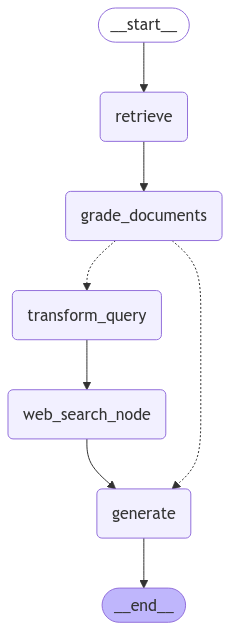

In [40]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Testing CRAG workflow

In [47]:
from pprint import pprint
import textwrap

# Run
inputs = {"question": "What's the bagel method?"}
# Print question
print("\nQuestion: %s" % inputs)
print("=" * 50)

for output in app.stream(inputs):
    for key, value in output.items():
        print("\n" + "=" * 50)
        print(f"**Node: '{key}'**")
        print("=" * 50 + "\n")

        # Special formatting for document retrieval
        if key == "retrieve" and "documents" in value:
            print("**Retrieved Documents:**\n")
            for i, doc in enumerate(value["documents"], 1):
                print(f"**Document {i}:**")
                print(f"Source: {doc.metadata.get('source', 'N/A')}")
                print(textwrap.fill(f"Content: {doc.page_content[:300]}...", width=80))
                print("=" * 50)

        # Special formatting for document grading
        elif key == "grade_documents":
            print("**Document Relevance Check:**\n")
            pprint(value, indent=2, width=80, depth=None)

        # Special formatting for transformed query
        elif key == "transform_query":
            print("**Transformed Query:**\n")
            pprint(value["question"], indent=2, width=80)

        # Special formatting for web search results
        elif key == "web_search_node" and "documents" in value:
            print("**Web Search Results:**\n")
            for i, doc in enumerate(value["documents"], 1):
                print(f"**Result {i}:**")
                print(f"{textwrap.fill(doc.page_content[:300] + '...', width=80)}")
                print("=" * 50)

        # Final Answer Formatting
        elif key == "generate":
            print("\n**Final Answer:**\n")
            print(textwrap.fill(value["generation"], width=80))

        else:
            pprint(value, indent=2, width=80, depth=None)  # Default formatting


Question: {'question': "What's the bagel method?"}
=======RETRIEVE=======
Total retrieved documents: 3
1. Source: https://www.kingarthurbaking.com/recipes/pain-de-campagne-country-bread-recipe
2. Source: https://www.kingarthurbaking.com/recipes/sourdough-pumpernickel-bread-recipe
3. Source: https://www.kingarthurbaking.com/recipes/naturally-leavened-sourdough-bread-recipe

**Node: 'retrieve'**

**Retrieved Documents:**

**Document 1:**
Source: https://www.kingarthurbaking.com/recipes/pain-de-campagne-country-bread-recipe
Content: Prevent your screen from going dark as you follow along.     Combine
all the ingredients in a large bowl or extra large (6-quart) dough rising
bucket. It's fine to use sourdough starter straight from the refrigerator if
that's where you keep it, though it's best if you've fed it at least once in
the...
**Document 2:**
Source: https://www.kingarthurbaking.com/recipes/sourdough-pumpernickel-bread-recipe
Content: best way to melt chocolateBaking GuidesBake for G

In [44]:
# One more test for CRAG

# Run
inputs = {"question": "What is self-attention?"}
# Print question
print("\nQuestion: %s" % inputs)
print("=" * 50)

for output in app.stream(inputs):
    for key, value in output.items():
        print("\n" + "=" * 50)
        print(f"**Node: '{key}'**")
        print("=" * 50 + "\n")

        # Special formatting for document retrieval
        if key == "retrieve" and "documents" in value:
            print("**Retrieved Documents:**\n")
            for i, doc in enumerate(value["documents"], 1):
                print(f"**Document {i}:**")
                print(f"Source: {doc.metadata.get('source', 'N/A')}")
                print(textwrap.fill(f"Content: {doc.page_content[:300]}...", width=80))
                print("=" * 50)

        # Special formatting for document grading
        elif key == "grade_documents":
            print("**Document Relevance Check:**\n")
            pprint(value, indent=2, width=80, depth=None)

        # Special formatting for transformed query
        elif key == "transform_query":
            print("**Transformed Query:**\n")
            pprint(value["question"], indent=2, width=80)

        # Special formatting for web search results
        elif key == "web_search_node" and "documents" in value:
            print("**Web Search Results:**\n")
            for i, doc in enumerate(value["documents"], 1):
                print(f"**Result {i}:**")
                print(f"{textwrap.fill(doc.page_content[:300] + '...', width=80)}")
                print("=" * 50)

        # Final Answer Formatting
        elif key == "generate":
            print("\n**Final Answer:**\n")
            print(textwrap.fill(value["generation"], width=80))

        else:
            pprint(value, indent=2, width=80, depth=None)  # Default formatting



Question: {'question': 'What is self-attention?'}
=======RETRIEVE=======
Total retrieved documents: 3
1. Source: https://www.kingarthurbaking.com/recipes/sourdough-pumpernickel-bread-recipe
2. Source: https://www.kingarthurbaking.com/recipes/naturally-leavened-sourdough-bread-recipe
3. Source: https://www.kingarthurbaking.com/recipes/pain-de-campagne-country-bread-recipe

**Node: 'retrieve'**

**Retrieved Documents:**

**Document 1:**
Source: https://www.kingarthurbaking.com/recipes/sourdough-pumpernickel-bread-recipe
Content: Main Menu...
**Document 2:**
Source: https://www.kingarthurbaking.com/recipes/naturally-leavened-sourdough-bread-recipe
Content: Main Menu...
**Document 3:**
Source: https://www.kingarthurbaking.com/recipes/pain-de-campagne-country-bread-recipe
Content: Main Menu...
=======CHECK DOCUMENT RELEVANCE TO QUESTION=======
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
=======ASSESS GRADED DOCUMENTS=======
=====